### **Importing Necessary Functions and Libraries**



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# **Image Preprocessing**

Manipulate sudoku images to work better with

### **Reading Image in Grayscale**

(203, 202)


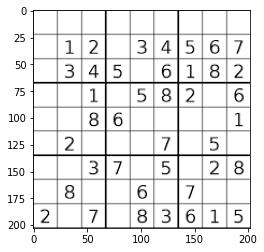

In [ ]:
# grayscale is a requirement for some other image libraries
img = cv2.imread('easy.png') # reading image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # converts the image into the gray color space

plt.imshow(gray,cmap='gray')

print(gray.shape)

### **Denoise with Gaussian Blur**

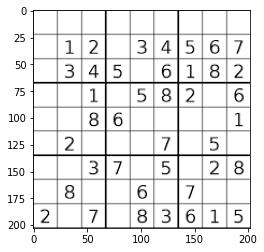

In [ ]:
dst = cv2.GaussianBlur(gray,(1,1),cv2.BORDER_DEFAULT) # applying gaussian blur

plt.imshow(dst,cmap='gray')

### **Applying Inverse Binary Threshold**

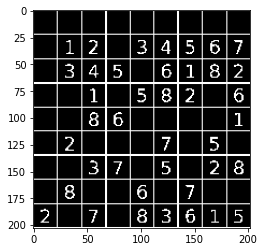

In [ ]:
# Images needed to be formated this way for the Hough Transform library.
ret,thresh_inv = cv2.threshold(gray, 180, 255,cv2.THRESH_BINARY_INV)

plt.imshow(thresh_inv,cmap='gray')

### **Applying Probabilistic Hough Transform**

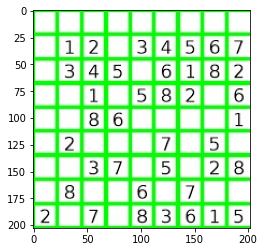

In [ ]:
# good tool in dececting interconnected lines as edges which helps in dececting the grid
minLineLength = 100
maxLineGap = 60
lines = cv2.HoughLinesP(thresh_inv,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
for l in lines:
    x1,y1,x2,y2 = l[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2, cv2.LINE_AA)

img_hough = cv2.imread('hough.jpg',0)
img_show = cv2.imread('hough.jpg')
plt.imshow(img_show, cmap='gray')

### **Finding Contour and Largest Board Area**

In [ ]:
# finding area of the board
contours,hierarchy = cv2.findContours(img_hough,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# finding the largest area
# declare variables
cnt = 0
max_area = 0

# go through each contour and see which contour has the largest area
for cont in contours:
    if cv2.contourArea(cont) > max_area:
        cnt = cont
        max_area = cv2.contourArea(cont)

print(max_area)

40602.0


### **Find Approximate Encompassing Polygon**

In [ ]:
epsilon = 0.01*cv2.arcLength(cnt,True) # accuracy of polygon
poly_approx = cv2.approxPolyDP(cnt, epsilon, True) # finding polygon

print(poly_approx)

[[[  0   0]]

 [[  0 202]]

 [[201 202]]

 [[201   0]]]


### **Applying Perspective Transform**

Getting exact corners of an desired object and reshaping it to the original shaped of the image. Example below.


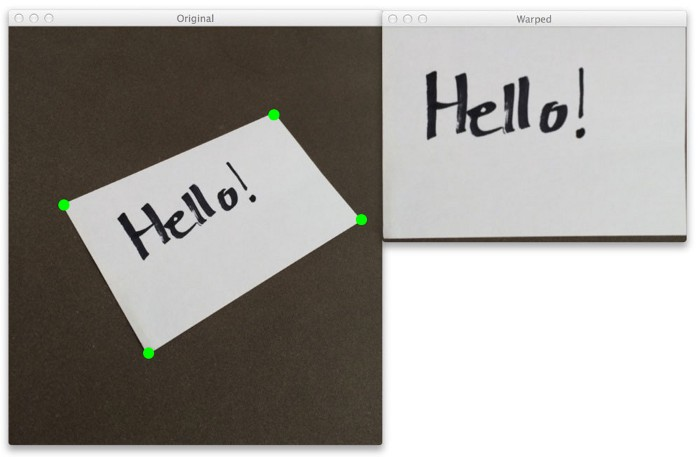

In [ ]:
# function that takes in approx polygon points (list) and returns them in ordered coordinates
def order_points(pts):
    # declaring a list of coordinates that will be ordered
    # 0;top-left, 1;top-right, 2;bottom-right, 3;bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum (0+0), whereas
    # the bottom-right point will have the largest sum (y+x)
    s = pts.sum(axis = 1)
    rect[0] = pts[0]
    rect[2] = pts[2]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference (0-x),
    # whereas the bottom-left will have the largest difference (y-0)
    diff = np.diff(pts, axis = 1)
    rect[3] = pts[3]
    rect[1] = pts[1]

    # return the ordered coordinates
    return rect

print(order_points(poly_approx))

[[  0.   0.]
 [  0. 202.]
 [201. 202.]
 [201.   0.]]


(201, 202)


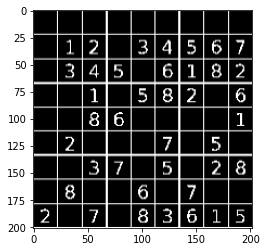

In [ ]:
# creating the new image from the ordered coordinates of the desired object
def four_point_transform(image, pts):
    # get the ordered coordinates and have them as seperate variables
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # square, then square root to get rid of negative

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # square, then square root to get rid of negative

    # Create the new image with the new dimensions with the desired object again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left order
    dst = np.array([
        [0, 0],
        [0, maxHeight - 1],
        [maxWidth - 1, maxHeight - 1],
        [maxWidth - 1, 0]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

img_PT = four_point_transform(thresh_inv,poly_approx)
print(img_PT.shape)
plt.imshow(img_PT, cmap='gray')

# **CNN For Digit Recognition**

### **Importing Libraries and Functions Needed**

In [ ]:
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from tensorflow.keras.layers import Dense, Dropout, Flatten # core layers

from keras.layers.normalization import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

from keras.datasets import mnist

### **Loading Training Data**

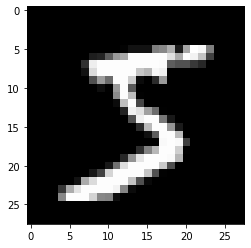

In [ ]:
# getting data
(X_train,y_train),(X_test,y_test)=mnist.load_data()

plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.show()

### **Normalizing Data**

In [ ]:
# size needed for Keras to work
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

# divide each pixel by 255 since RGB
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
# convert the dependent variable in the form of integers to a binary class matrix
from keras.utils import np_utils
y_train=np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes=y_test.shape[1]

### **Designing Model**

In [ ]:
## Initialize the model
model = Sequential()

## Declare the layers
# 1st convolutional layer
layer_1 = Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1))
# 2nd convolutional layer
layer_2 = Conv2D(64, kernel_size=3, activation='relu')
# flattening layer to convert to 1D array
layer_3 = Flatten()
# dense layer to classify data
layer_4 = Dense(10, activation='softmax')

## Add the layers to the model
model.add(layer_1)
model.add(layer_2)
model.add(layer_3)
model.add(layer_4)

### **Training Model**

In [ ]:
# compile model with an loss function, an optimizer function and a metric to assess model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# training model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

# save model to use again
model.save("digit_model.h5")

### **Testing Model**

(128, 128)

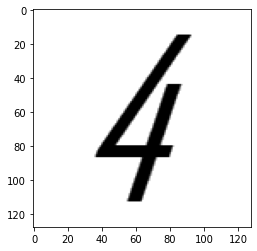

In [ ]:
test_image = cv2.imread('img005-00003.png',0) #reading in grayscale

plt.imshow(test_image,cmap='gray')
test_image.shape

In [ ]:
from tensorflow.keras.models import load_model
# loading trained model
new_model = load_model('digit_model.h5')

In [ ]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image

# manipulating image so it can be read
ret, thresh = cv2.threshold(test_image.copy(), 75, 255, cv2.THRESH_BINARY_INV)
resized_digit = cv2.resize(thresh, (28,28))
resized_digit = resized_digit.reshape(1,28,28,1)

# predicting the digit but output is array
prediction = new_model.predict(resized_digit)
prediction

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

### **Function For Getting Digit From Prediction**

In [ ]:
# function to output prediction as only 1 number
def prediction(test_image):

    # get prediction
    classes = np.argmax(new_model.predict(test_image), axis=-1)

    # see which place it was in the array and output that place number
    if classes == [[0]]:
        return 0
    elif classes == [[1]]:
        return 1
    elif classes == [[2]]:
        return 2
    elif classes == [[3]]:
        return 3
    elif classes == [[4]]:
        return 4
    elif classes == [[5]]:
        return 5
    elif classes == [[6]]:
        return 6
    elif classes == [[7]]:
        return 7
    elif classes == [[8]]:
        return 8
    elif classes == [[9]]:
        return 9

In [ ]:
print(prediction(resized_digit))

4


# **Digit Extraction**

In [ ]:
import tensorflow as tf
from PIL import Image

### **Position of Cells**

In [ ]:
#creating a function to get the different position of cells
def getCellPositions(img_PT):
    #resizing the images to take the shape of the NN model
    img_PT = cv2.resize(img,(252,252))
    #computing position of each cell and storing in an array of arrays
    cell_positions = []

    # getting width and height of image
    width = img_PT.shape[1]
    height = img_PT.shape[0]

    # quotient of 9 since 9 x 9 grid
    cell_width = width//9
    cell_height = height//9

    x1,x2,y1,y2 = 0,0,0,0

    # going through each of the 81 cells and getting coordinates
    for i in range(9):
        y2 = y1 + cell_height
        x1 = 0
        for j in range(9):
            x2 = x1 + cell_width
            current_cell = [x1,x2,y1,y2]
            cell_positions.append(current_cell)
            x1 = x2
        y1 = y2
    return cell_positions

### **Get Digit of Each Cell**

In [ ]:
#using the trained model to predict the digits in each cell, if cell is empty fix with 0
def predictDigit(cell,img):
    # var for position of digit
    pos = []
    # resizing cell image to match NN Model
    img = cv2.resize(img,(252,252))
    img = img[cell[2]+2:cell[3]-3,cell[0]+2:cell[1]-3]
    # finding contours in cell
    contours,hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 0: # if there are contours, see if digit
        for c in contours: # go through each contour
            x,y,w,h = cv2.boundingRect(c) # get x and y coor and width and height data of each contour
            # if the contour is sufficiently large, it must be a digit
            if (w < 15 and x > 2) and (h < 25 and y > 2):
                pos.append((x,y,x+w,y+h))
                break
    if pos == []: # if no contours, then no digit
        result = 0
    if pos: # if there was a digit
        # create and resize the cell with the digit
        img1 = img[(pos[0][1]):(pos[0][3]),(pos[0][0]):(pos[0][2])]
        img1 = cv2.resize(img,(28,28))
        img1 = img1.reshape(1,28,28,1)

        # send the image through the model and get a digit
        result = prediction(img1)
    # return the digit of the cell
    return result

### **Get ALL Digits of ALL Cells**

In [ ]:
# function to loop through the cell positions got from the getCellPositions function and calls the predictDigit function to get the cell's digit
def extractSudokuDigits(img_PT):
    cell_digits,num = [],0 # declare var
    cells = getCellPositions(img_PT) # getting all cell positions
    for cell in range(len(cells)): # going through all cells
        num = predictDigit(cells[cell],img_PT) # predicting digit in each cell
        cell_digits.append(num) # appending that digit into the list of all digits
    #n = 9
    #cell_digits = [cell_digits[i:i+n] for i in range(0, len(cell_digits), n)]
    return cell_digits

### **Importing Necessary Functions**

In [ ]:
import copy
import keras
import numpy as np
from model import get_model
from data_preprocess import get_data

### **Loading Training Data**

In [ ]:
x_train, x_test, y_train, y_test = get_data('sudoku.csv')

### **Training Model**

In [ ]:
model = get_model()

adam = keras.optimizers.Adam(lr=.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam)

model.fit(x_train, y_train, batch_size=64, epochs=2)

In [ ]:
model.save('sudoku1.h5')

### **Loading Pre-Trained Model**

In [ ]:
model = keras.models.load_model('sudoku1.h5')

In [ ]:
def norm(a):

    return (a/9)-.5

In [ ]:
def denorm(a):

    return (a+.5)*9


In [ ]:
def inference_sudoku(sample):

    '''
        This function solve the sudoku by filling blank positions one by one.
    '''

    feat = copy.copy(sample)

    while(1):

        out = model.predict(feat.reshape((1,9,9,1)))
        out = out.squeeze()

        pred = np.argmax(out, axis=1).reshape((9,9))+1
        prob = np.around(np.max(out, axis=1).reshape((9,9)), 2)

        feat = denorm(feat).reshape((9,9))
        mask = (feat==0)

        if(mask.sum()==0):
            break

        prob_new = prob*mask

        ind = np.argmax(prob_new)
        x, y = (ind//9), (ind%9)

        val = pred[x][y]
        feat[x][y] = val
        feat = norm(feat)

    return pred

In [ ]:
def test_accuracy(feats, labels):

    correct = 0

    for i,feat in enumerate(feats):

        pred = inference_sudoku(feat)

        true = labels[i].reshape((9,9))+1

        if(abs(true - pred).sum()==0):
            correct += 1

    print(correct/feats.shape[0])

In [ ]:
test_accuracy(x_test[:100], y_test[:100])

1.0


In [ ]:
def solve_sudoku(game):

    game = game.replace('\n', '')
    game = game.replace(' ', '')
    game = np.array([int(j) for j in game]).reshape((9,9,1))
    game = norm(game)
    game = inference_sudoku(game)
    return game

In [ ]:
game = '''004300209005009001070060043006002087190007400050083000600000105003508690042910300'''

game = solve_sudoku(game)

print('solved puzzle:\n')
print(game)

solved puzzle:

[[8 6 4 3 7 1 2 5 9]
 [3 2 5 8 4 9 7 6 1]
 [9 7 1 2 6 5 8 4 3]
 [4 3 6 1 9 2 5 8 7]
 [1 9 8 6 5 7 4 3 2]
 [2 5 7 4 8 3 9 1 6]
 [6 8 9 7 3 4 1 2 5]
 [7 1 3 5 2 8 6 9 4]
 [5 4 2 9 1 6 3 7 8]]
